<a href="https://colab.research.google.com/github/sisatput/IBM-Data-Classification/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Colab (install & auth Replicate)

In [ ]:
# --- INSTALL ---
!pip -q install kaggle replicate datasets transformers evaluate rouge-score

# --- KAGGLE AUTH (upload kaggle.json Anda) ---
from google.colab import files
import os, shutil

uploaded = files.upload()  # pilih kaggle.json Anda
if "kaggle.json" not in uploaded:
    raise FileNotFoundError("File 'kaggle.json' tidak ditemukan. Pastikan Anda memilihnya saat upload.")

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# --- REPLICATE AUTH (gunakan Colab Secrets) ---
# Di Colab: klik ikon 🔑 (Secrets), lalu tambahkan key: REPLICATE_API_TOKEN
try:
    from google.colab import userdata
    REPLICATE_API_TOKEN = userdata.get("REPLICATE_API_TOKEN")
    if not REPLICATE_API_TOKEN:
        raise ValueError("Secret 'REPLICATE_API_TOKEN' belum di-set. Tambahkan via Colab Secrets.")
    os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN
except Exception as e:
    raise RuntimeError("Gagal mengambil secret 'REPLICATE_API_TOKEN' dari Colab Secrets.") from e


Saving kaggle.json to kaggle.json


Ambil dataset AG News dari Kaggle

In [ ]:
!kaggle datasets download -d amananandrai/ag-news-classification-dataset -q
!unzip -o ag-news-classification-dataset.zip -d agnews > /dev/null

import pandas as pd
train_df = pd.read_csv("agnews/train.csv")
test_df  = pd.read_csv("agnews/test.csv")

# Gabung title + description
for df in (train_df, test_df):
    df["text"] = df["Title"].astype(str) + ". " + df["Description"].astype(str)

label_map = {1:"World", 2:"Sports", 3:"Business", 4:"Sci/Tech"}


Dataset URL: https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset
License(s): unknown


Visualisasi Distribusi Data (EDA)

/tmp/ipython-input-2442278900.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label_name', data=train_df, order=order, palette="viridis")


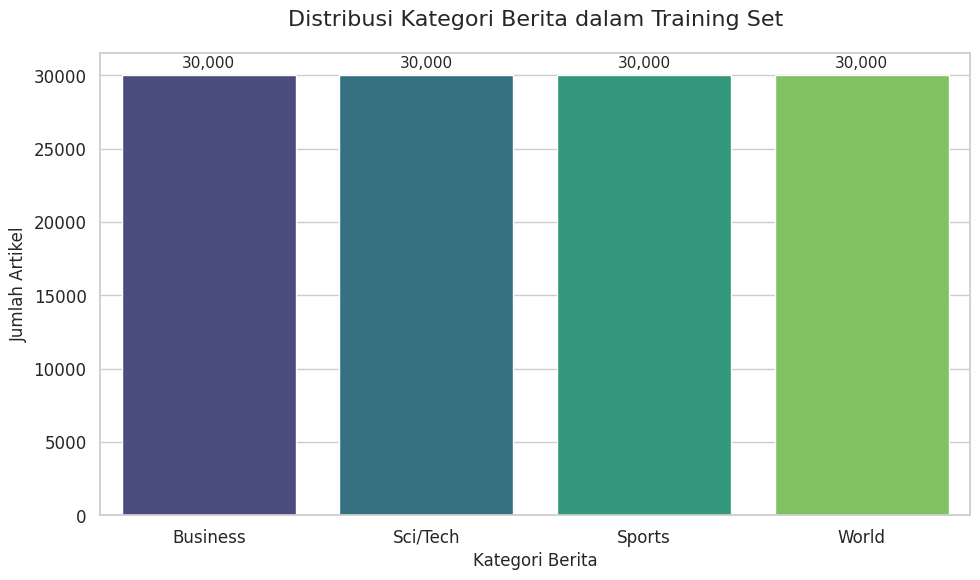

In [ ]:
# --- Sisipkan kode ini setelah Anda memuat train_df ---
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping dari Class Index ke Nama Label yang sudah Anda buat
label_map = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
train_df['label_name'] = train_df['Class Index'].map(label_map)

# Atur style plot
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

# Urutkan bar berdasarkan jumlahnya
order = train_df['label_name'].value_counts().index
ax = sns.countplot(x='label_name', data=train_df, order=order, palette="viridis")

# Tambahkan judul dan label
ax.set_title('Distribusi Kategori Berita dalam Training Set', fontsize=16, pad=20)
ax.set_xlabel('Kategori Berita', fontsize=12)
ax.set_ylabel('Jumlah Artikel', fontsize=12)

# Tambahkan anotasi jumlah pada setiap bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=11, xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
# Simpan gambar untuk laporan Anda
plt.savefig("distribusi_kategori_berita.png")
plt.show()

Fungsi helper: panggil Granite di Replicate

In [ ]:
import replicate, textwrap, time

GRANITE_MODEL = "ibm-granite/granite-3.3-8b-instruct"  # model slug di Replicate

SYSTEM_PROMPT = (
    "You are an analytical assistant. Respond in plain JSON only."
)

def granite_json(prompt, max_tokens=256, temperature=0.2):
    full_prompt = f"<|system|>\n{SYSTEM_PROMPT}\n<|user|>\n{prompt}\n<|assistant|>"
    out = replicate.run(
        f"{GRANITE_MODEL}",
        input={
            "prompt": full_prompt,
            "max_tokens": max_tokens,
            "temperature": temperature,
        },
    )
    # Replicate stream returns an iterator of chunks; join menjadi string
    text = "".join(list(out)).strip()
    return text


Zero-/Few-shot Classification dengan Granite

In [ ]:
import json, numpy as np
from tqdm.auto import tqdm

CLASS_LABELS = ["World","Sports","Business","Sci/Tech"]

FEW_SHOTS = [
    {"text":"Fed hikes rates amid inflation concerns.", "label":"Business"},
    {"text":"Mars rover sends new images from crater.", "label":"Sci/Tech"},
    {"text":"Local team clinches championship title.", "label":"Sports"},
    {"text":"UN holds summit on global refugee crisis.", "label":"World"},
]

def build_classification_prompt(text):
    examples = "\n".join(
        [f'{{"text":"{e["text"]}","label":"{e["label"]}"}}' for e in FEW_SHOTS]
    )
    instr = f"""
Task: Classify the NEWS text into one of labels: {CLASS_LABELS}.
Return JSON with keys: label, confidence (0-1), rationale (short string).

Few-shot examples (JSON lines):
{examples}

Now classify this text:
{text}
Return only JSON.
"""
    return instr.strip()

# Contoh batch kecil untuk validasi cepat
sample_val = test_df.sample(50, random_state=42).copy()
preds = []
for t in tqdm(sample_val["text"].tolist()):
    js = granite_json(build_classification_prompt(t), max_tokens=180)
    # Robust parse
    try:
        j = json.loads(js)
        label = j.get("label","")
    except:
        label = ""
    preds.append(label)

sample_val["pred_label"] = preds
sample_val["true_label"] = sample_val["Class Index"].map(label_map)
acc = (sample_val["pred_label"] == sample_val["true_label"]).mean()
acc


  0%|          | 0/50 [00:00<?, ?it/s]

np.float64(0.9)

Summarization dengan Granite

In [ ]:
def build_summarize_prompt(text, target_words=50):
    return f"""
Summarize the following news article in about {target_words} words.
Use concise Indonesian language if possible. Return JSON with keys: summary.

Article:
{text}
"""

# Coba 3 contoh ringkasan
demo = test_df.sample(3, random_state=7)["text"].tolist()
summaries = []
for t in demo:
    js = granite_json(build_summarize_prompt(t, target_words=60), max_tokens=220)
    try:
        j = json.loads(js); summaries.append(j["summary"])
    except:
        summaries.append(js)

for s in summaries:
    print("-"*80); print(s)


--------------------------------------------------------------------------------
Motorola berusaha memperkuat desain produk mereka. Pada ruangan kantor di tingkat 26 dengan pandangan langit Semenan Lake, sekitar 40 desainer industri, jeneng mekanik, dan ahli bidang yang bervariasi dari antropologi hingga musikology bekerja sama untuk menciptakan produk dengan desain yang lebih inovatif dan relevan dengan kebutuhan konsumen.
--------------------------------------------------------------------------------
Rally di Wall Street diharapkan terus terjadi hingga Desember, tetapi terdapat berbagai berita buruk yang mungkin menyebabkan perkembangan beli terhenti.
--------------------------------------------------------------------------------
Poland akan mengurangi sederet satu dari tiga dari pasukan milinya di Iraq pada tahun berikutnya. Menteri Pertahanan Poland, Jerzy Szmajdzinski, mengumumkan rencana tersebut.


Baseline Classifier (untuk pembanding di laporan)

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate, numpy as np

base_df = train_df[["text","Class Index"]].rename(columns={"Class Index":"label"}).copy()
base_df["label"] = base_df["label"] - 1  # 0..3

train_small = base_df.sample(20000, random_state=7)  # cepat saja
val_small   = test_df[["text","Class Index"]].rename(columns={"Class Index":"label"}).copy()
val_small["label"] = val_small["label"] - 1

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tok_fn(ex):
    return tok(ex["text"], truncation=True, padding="max_length", max_length=256)

train_ds = Dataset.from_pandas(train_small).map(tok_fn, batched=True)
val_ds   = Dataset.from_pandas(val_small).map(tok_fn, batched=True)

# keep only features yang dibutuhkan Trainer
keep_cols = ["input_ids", "attention_mask", "label"]
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep_cols]).with_format("torch")
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names if c not in keep_cols]).with_format("torch")

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

metric = evaluate.load("accuracy")
def comp(eval_pred):
    logits, labels = eval_pred
    return metric.compute(predictions=np.argmax(logits,axis=-1), references=labels)

# NOTE: di Transformers v5, gunakan 'eval_strategy' (bukan 'evaluation_strategy')
# dan tambahkan 'logging_strategy' bila ingin pakai logging_steps
args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=100,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=comp,
)

trainer.train()
trainer.evaluate()


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.243000,0.249161,0.921579


{'eval_loss': 0.24916110932826996,
 'eval_accuracy': 0.921578947368421,
 'eval_runtime': 58.9402,
 'eval_samples_per_second': 128.944,
 'eval_steps_per_second': 4.038,
 'epoch': 1.0}

Simpan hasil (untuk repo & slide)

In [ ]:
# Simpan ringkasan & prediksi Granite untuk contoh presentasi
export = sample_val[["text","true_label","pred_label"]].copy()
export.to_csv("granite_demo_preds.csv", index=False)

# (opsional) hitung ROUGE ringkasan bila punya reference
from rouge_score import rouge_scorer
# scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
# ... hitung skor jika tersedia reference summary


Visualisasi Perbandingan Performa Model

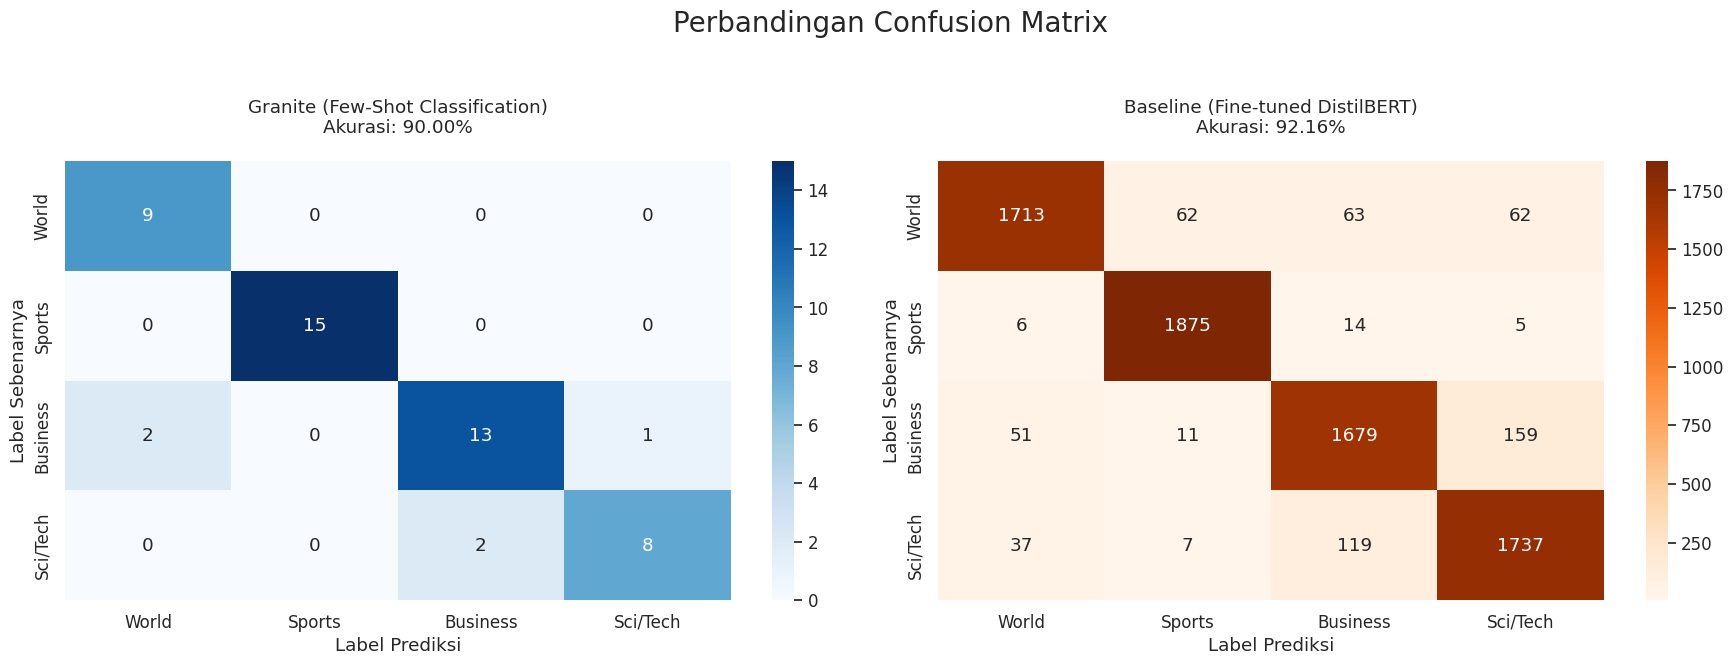

In [ ]:
# --- Sisipkan kode ini di akhir notebook ---
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# 1. Muat hasil prediksi dari Granite (file ini dibuat di notebook Anda)
granite_results = pd.read_csv("granite_demo_preds.csv")

# 2. Dapatkan prediksi dari model baseline (DistilBERT)
#    Kita perlu menjalankan predict() pada data validasi
val_preds_output = trainer.predict(val_ds)
# val_preds_output.predictions adalah logits, kita butuh argmax untuk mendapatkan label
baseline_pred_labels_int = np.argmax(val_preds_output.predictions, axis=1)

# Ambil label asli dari validation set
true_labels_int = val_ds["label"]
true_labels_name = [list(label_map.values())[i] for i in true_labels_int]

# Mapping prediksi baseline dari integer ke nama label
baseline_pred_labels_name = [list(label_map.values())[i] for i in baseline_pred_labels_int]

# 3. Siapkan label untuk Confusion Matrix Granite
#    Pastikan urutan label konsisten
labels_order = ["World", "Sports", "Business", "Sci/Tech"]
granite_true = granite_results["true_label"]
granite_pred = granite_results["pred_label"]

# 4. Hitung Confusion Matrix untuk kedua model
cm_granite = confusion_matrix(granite_true, granite_pred, labels=labels_order)
cm_baseline = confusion_matrix(true_labels_name, baseline_pred_labels_name, labels=labels_order)

# 5. Buat visualisasi
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Perbandingan Confusion Matrix', fontsize=20)

# Confusion Matrix Granite (Few-Shot)
sns.heatmap(cm_granite, annot=True, fmt='d', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order, ax=axes[0])
axes[0].set_title(f'Granite (Few-Shot Classification)\nAkurasi: {accuracy_score(granite_true, granite_pred):.2%}', pad=20)
axes[0].set_xlabel('Label Prediksi')
axes[0].set_ylabel('Label Sebenarnya')

# Confusion Matrix Baseline (Fine-Tuned)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Oranges', xticklabels=labels_order, yticklabels=labels_order, ax=axes[1])
axes[1].set_title(f'Baseline (Fine-tuned DistilBERT)\nAkurasi: {accuracy_score(true_labels_name, baseline_pred_labels_name):.2%}', pad=20)
axes[1].set_xlabel('Label Prediksi')
axes[1].set_ylabel('Label Sebenarnya')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Simpan gambar untuk laporan Anda
plt.savefig("perbandingan_confusion_matrix.png")
plt.show()